<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_R/blob/main/Colab_Notebook/02_07_06_02_survival_analysis_baseline_hazard_function_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![All-test](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 6.2  Baseline Hazard Function of Joint Models


In **joint models** for longitudinal and time-to-event data, we simultaneously model:

- A **longitudinal submodel** (e.g., CD4 cell count over time),
- An **event submodel** (e.g., time to death).

The event submodel is typically a **relative risk (Cox-type) model** of the form:

$$
h_i(t) = h_0(t) \exp\bigl( \mathbf{w}_i^\top \boldsymbol{\alpha} + \text{association terms} \bigr)
$$

- $ h_i(t) $: hazard for individual $i$ at time $t$,
- $ h_0(t) $: **baseline hazard function** — the hazard when all covariates and association terms are zero,
- $ \mathbf{w}_i $: baseline covariates (e.g., treatment),
- The **association terms** link the longitudinal process to the event risk (e.g., current value of a biomarker).


### How is this different from a "standard" shared random effects joint model?


- In **classical joint models**, $ h_0(t) $ is often left **unspecified** (semi-parametric, like in Cox regression) or approximated via splines.
- In **`JMbayes2`**, the baseline hazard is **explicitly modeled** using flexible parametric forms (e.g., B-splines, piecewise constants, Weibull).

- This allows:

  - Full Bayesian inference,
  - Smooth estimation of $ h_0(t) $,
  - Extrapolation beyond observed event times (with appropriate bases),
  - Stratified or heterogeneous baseline hazards.

Crucially, **`JMbayes2` does not use a Cox partial likelihood**. Instead, it **fully parametrizes** $ h_0(t) $, which is essential for:

- Dynamic predictions,
- Proper posterior inference,
- Integration with Stan-based MCMC sampling.


## Setup R in Python Runtype - Install {rpy2}
{rpy2} is a Python package that provides an interface to the R programming language, allowing Python users to run R code, call R functions, and manipulate R objects directly from Python. It enables seamless integration between Python and R, leveraging R's statistical and graphical capabilities while using Python's flexibility. The package supports passing data between the two languages and is widely used for statistical analysis, data visualization, and machine learning tasks that benefit from R's specialized libraries.

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.1
Uninstalling rpy2-3.5.1:
  Successfully uninstalled rpy2-3.5.1
  Using cached rpy2-3.5.1-cp312-cp312-linux_x86_64.whl


## Mount Google Drive

In [2]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Implementing Different Baseline Hazard Specifications in R


Baseline Hazard can be implemented using the {JMbayes2} package in R for **Bayesian joint modeling of longitudinal and time-to-event (survival) data**. It enables simultaneous analysis of repeated longitudinal measurements (e.g., biomarker trajectories) and event outcomes (e.g., death or disease progression) by linking them through shared random effects or other association structures. Built on **Stan** for efficient Hamiltonian Monte Carlo sampling, {JMbayes2} supports flexible model specifications, including linear, generalized linear, or nonlinear mixed-effects models for the longitudinal submodel and Cox or accelerated failure time models for the survival submodel.

![](https://github.com/zia207/Survival_Analysis_R/blob/main/Colab_Notebook/Image/jbbyaes2_logo.png?raw=1){width="120"}


We’ll use the **AIDS dataset** included in `JMbayes2`, which contains:

- Longitudinal CD4 cell counts (square-root transformed),
- Time-to-death with censoring,
- Treatment group (`drug`: ddC or ddI).


### Install Required R Packages


Following R packages are required to run this notebook. If any of these packages are not installed, you can install them using the code below:


In [3]:
%%R
packages <-c(
		 'tidyverse',
		 'survival',
		 'survminer',
		 'ggsurvfit',
		 'tidycmprsk',
		 'ggfortify',
		 'timereg',
		 'cmprsk',
		 'condSURV',
		 'riskRegression',
		 'prodlim',
		 'lava',
		 'mstate',
		 'regplot',
		 'cmprskcoxmsm',
		 'GLMMadaptive',
		 'nlme',
		 'lme4',
		 'lattice',
		 'JM',
		 'joineR',
		 'joineRML',
		 'JMbayes2'

		 )


### Install missing packages

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')
devtools::install_github("ItziarI/WeDiBaDis", lib='drive/My Drive/R/')


### Verify Installation

In [4]:
%%R
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:


  method        from 
  nobs.multinom broom

  method         from 
  augment.mjoint broom
  glance.mjoint  broom
  tidy.mjoint    broom



     tidyverse       survival      survminer      ggsurvfit     tidycmprsk 
          TRUE           TRUE           TRUE           TRUE           TRUE 
     ggfortify        timereg         cmprsk       condSURV riskRegression 
          TRUE           TRUE           TRUE           TRUE           TRUE 
       prodlim           lava         mstate        regplot   cmprskcoxmsm 
          TRUE           TRUE           TRUE           TRUE           TRUE 
  GLMMadaptive           nlme           lme4        lattice             JM 
          TRUE           TRUE           TRUE           TRUE           TRUE 
        joineR       joineRML       JMbayes2 
          TRUE           TRUE           TRUE 


### Load Packages

In [5]:
%%R
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))

In [6]:
%%R
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])

Successfully loaded packages:
 [1] "package:JMbayes2"       "package:joineRML"       "package:joineR"        
 [4] "package:JM"             "package:splines"        "package:MASS"          
 [7] "package:lattice"        "package:lme4"           "package:Matrix"        
[10] "package:nlme"           "package:GLMMadaptive"   "package:cmprskcoxmsm"  
[13] "package:regplot"        "package:mstate"         "package:lava"          
[16] "package:prodlim"        "package:riskRegression" "package:condSURV"      
[19] "package:cmprsk"         "package:timereg"        "package:ggfortify"     
[22] "package:tidycmprsk"     "package:ggsurvfit"      "package:survminer"     
[25] "package:ggpubr"         "package:survival"       "package:lubridate"     
[28] "package:forcats"        "package:stringr"        "package:dplyr"         
[31] "package:purrr"          "package:readr"          "package:tidyr"         
[34] "package:tibble"         "package:ggplot2"        "package:tidyverse"     
[37] "pack

### Load data

In [7]:
%%R
data(aids)
data(aids.id)  # baseline/event data (one row per patient)

### Fit a longitudinal submodel


We model square-root CD4 counts with a natural spline for time and treatment interaction:


In [8]:
%%R
fm <- lme(sqrt(CD4) ~ ns(obstime, 2) * drug,
          data = aids,
          random = list(patient = pdDiag(~ ns(obstime, 2))))

### Fit a Cox model for the event process

In [9]:
%%R
CoxFit <- coxph(Surv(Time, death) ~ drug, data = aids.id)


> Note: `coxph()` is only used to **extract design information** (covariates, event times). `JMbayes2` will **replace** the baseline hazard with its own parametric form.



### Different Baseline Hazard Specifications


All models below use the same longitudinal and covariate structure but differ in how $ h_0(t) $ is modeled.


#### Penalized B-splines (Quadratic, on Original Time Scale) - Default

In [10]:
%%R
# Fit joint model with default B-splines baseline hazard
jointFit1 <- jm(CoxFit, fm, time_var = "obstime")
summary(jointFit1)


Call:
jm(Surv_object = CoxFit, Mixed_objects = fm, time_var = "obstime")

Data Descriptives:
Number of Groups: 467		Number of events: 188 (40.3%)
Number of Observations:
  sqrt(CD4): 1405

                 DIC     WAIC      LPML
marginal    3961.217 4190.783 -2095.777
conditional 5798.150 5659.639 -3298.692

Random-effects covariance matrix:
                           
       StdDev   Corr       
(Intr) 0.8704 (Intr) n(,2)1
n(,2)1 0.6268              
n(,2)2 0.2148              

Survival Outcome:
                    Mean  StDev    2.5%   97.5%      P   Rhat
drugddI           0.3573 0.1991 -0.0265  0.7335 0.0727 1.0014
value(sqrt(CD4)) -1.0786 0.1258 -1.3301 -0.8427 0.0000 1.0212

Longitudinal Outcome: sqrt(CD4) (family = gaussian, link = identity)
                   Mean  StDev    2.5%   97.5%      P   Rhat
(Intercept)      2.4988 0.0612  2.3805  2.6175 0.0000 1.0004
ns(obstime, 2)1 -0.7480 0.0858 -0.9142 -0.5769 0.0000 1.0036
ns(obstime, 2)2 -0.4248 0.0904 -0.5818 -0.2442 0.0000 1.1

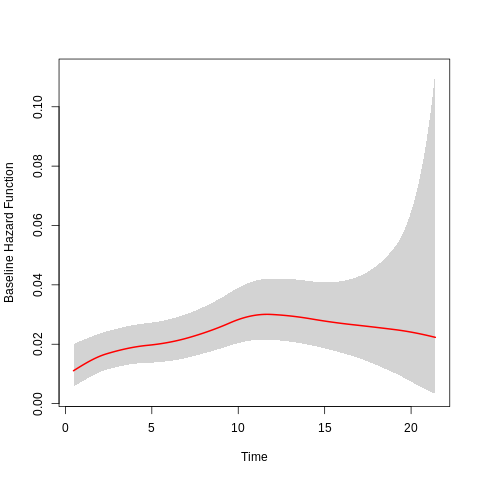

In [11]:
%%R
# Plot estimated baseline hazard
JMbayes2:::plot_hazard(jointFit1)


- **Basis**: Quadratic B-splines (`Bsplines_degree = 2`),
- **Knots**: 9 equidistant knots in $ (10^{-8}, T_{\max}) $,
- **Penalty**: Second-order difference penalty on spline coefficients,
- **Prior on smoothing**: $ \tau \sim \text{Gamma}(5, 0.5) $.

> Smooth, flexible, default choice.



####  Natural Cubic Splines on Log(Time)


Avoids issues with $ H_0(0) > 0 $ and improves behavior near time zero.


In [12]:
%%R
# update joint model with natural cubic splines on log(time)
jointFit2 <- update(jointFit1, base_hazard = "log time, ns")
summary(jointFit2)


Call:
jm(Surv_object = CoxFit, Mixed_objects = fm, time_var = "obstime", 
    base_hazard = "log time, ns")

Data Descriptives:
Number of Groups: 467		Number of events: 188 (40.3%)
Number of Observations:
  sqrt(CD4): 1405

                 DIC     WAIC      LPML
marginal    3961.217 4190.783 -2095.777
conditional 5798.150 5659.639 -3298.692

Random-effects covariance matrix:
                           
       StdDev   Corr       
(Intr) 0.8704 (Intr) n(,2)1
n(,2)1 0.6268              
n(,2)2 0.2148              

Survival Outcome:
                    Mean  StDev    2.5%   97.5%      P   Rhat
drugddI           0.3573 0.1991 -0.0265  0.7335 0.0727 1.0014
value(sqrt(CD4)) -1.0786 0.1258 -1.3301 -0.8427 0.0000 1.0212

Longitudinal Outcome: sqrt(CD4) (family = gaussian, link = identity)
                   Mean  StDev    2.5%   97.5%      P   Rhat
(Intercept)      2.4988 0.0612  2.3805  2.6175 0.0000 1.0004
ns(obstime, 2)1 -0.7480 0.0858 -0.9142 -0.5769 0.0000 1.0036
ns(obstime, 2)2 -0.424

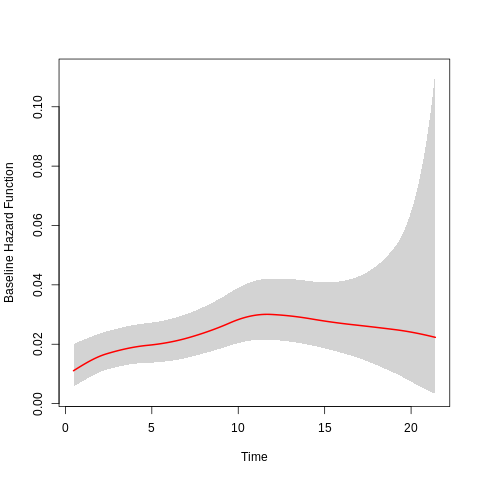

In [13]:
%%R
# Plot estimated baseline hazard with natural cubic splines on log(time)
JMbayes2:::plot_hazard(jointFit2)


- Equivalent to:


In [14]:
%%R
update(jointFit1,
         timescale_base_hazard = "log",
         basis = "ns")


Call:
jm(Surv_object = CoxFit, Mixed_objects = fm, time_var = "obstime", 
    timescale_base_hazard = "log", basis = "ns")

Random-effects covariance matrix:
                           
       StdDev   Corr       
(Intr) 0.8704 (Intr) n(,2)1
n(,2)1 0.6268              
n(,2)2 0.2148              

Survival Outcome:
                    Mean  StDev    2.5%   97.5%      P   Rhat
drugddI           0.3573 0.1991 -0.0265  0.7335 0.0727 1.0014
value(sqrt(CD4)) -1.0786 0.1258 -1.3301 -0.8427 0.0000 1.0212

Longitudinal Outcome: sqrt(CD4) (family = gaussian, link = identity)
                   Mean  StDev    2.5%   97.5%      P   Rhat
(Intercept)      2.4988 0.0612  2.3805  2.6175 0.0000 1.0004
ns(obstime, 2)1 -0.7480 0.0858 -0.9142 -0.5769 0.0000 1.0036
ns(obstime, 2)2 -0.4248 0.0904 -0.5818 -0.2442 0.0000 1.1638
drugddI          0.0463 0.0866 -0.1235  0.2143 0.5951 1.0003
n(,2)1           0.1878 0.1196 -0.0414  0.4196 0.1111 1.0143
n(,2)2          -0.1229 0.1295 -0.3562  0.1338 0.3556 1.1478


- **Natural cubic splines** enforce linearity beyond boundary knots,
- Works on **log(time)**, which often better captures hazard dynamics in chronic diseases.

> Recommended for extrapolation and improved boundary behavior.



#### Piecewise Constant Hazard


Assumes hazard is constant within intervals (like in Poisson models).


In [15]:
%%R
jointFit3 <- update(jointFit1,
                    base_hazard = "piecewise constant",
                    base_hazard_segments = 5L)
summary(jointFit3)


Call:
jm(Surv_object = CoxFit, Mixed_objects = fm, time_var = "obstime", 
    base_hazard = "piecewise constant", base_hazard_segments = 5L)

Data Descriptives:
Number of Groups: 467		Number of events: 188 (40.3%)
Number of Observations:
  sqrt(CD4): 1405

                 DIC     WAIC      LPML
marginal    4012.814 4192.542 -2096.763
conditional 6031.951 5842.970 -3369.631

Random-effects covariance matrix:
                           
       StdDev   Corr       
(Intr) 0.8717 (Intr) n(,2)1
n(,2)1 0.6475              
n(,2)2 0.2577              

Survival Outcome:
                    Mean  StDev    2.5%   97.5%      P   Rhat
drugddI           0.3451 0.1710  0.0084  0.6698 0.0444 1.0034
value(sqrt(CD4)) -1.0761 0.1171 -1.3201 -0.8547 0.0000 1.0210

Longitudinal Outcome: sqrt(CD4) (family = gaussian, link = identity)
                   Mean  StDev    2.5%   97.5%      P   Rhat
(Intercept)      2.4990 0.0611  2.3775  2.6198 0.0000 1.0013
ns(obstime, 2)1 -0.7471 0.0837 -0.9128 -0.5849 0.0

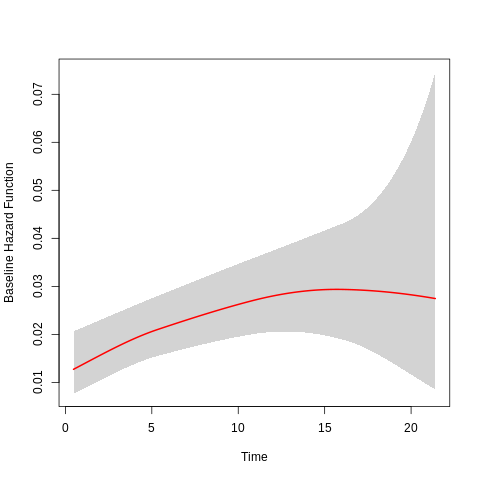

In [16]:
%%R
JMbayes2:::plot_hazard(jointFit3)


- Splits follow-up into 5 equal-length intervals,
- Estimates one hazard level per interval,
- **Not smooth**, but simple and interpretable.

>  Use for robustness checks or when smoothness is not critical.


#### Piecewise Linear Hazard (on Log Time)


Connects hazard estimates with straight lines.


In [17]:
%%R
jointFit4 <- update(jointFit1,
                    base_hazard = "piecewise linear, log time",
                    base_hazard_segments = 3L,
                    priors = list(penalized_bs_gammas = FALSE))

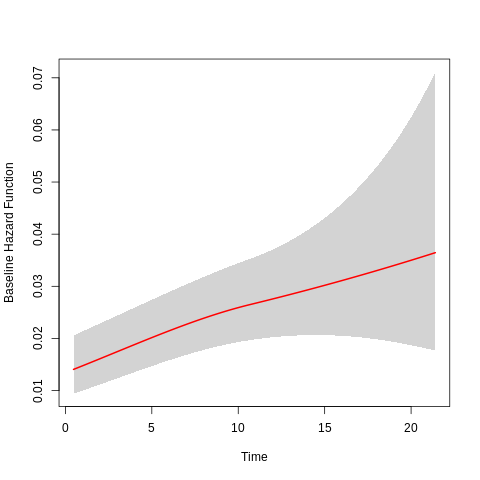

In [19]:
%%R
JMbayes2:::plot_hazard(jointFit4)


- Uses 3 segments → 4 knots → 3 linear pieces,
- **No penalization** (flat normal prior on coefficients),
- Less smooth than splines but more flexible than piecewise constant.



#### Weibull Baseline Hazard


Parametric, assumes $ h_0(t) = \lambda \rho t^{\rho - 1} $.


In [18]:
%%R
jointFit5 <- update(jointFit1, base_hazard = "weibull")
summary(jointFit5)


Call:
jm(Surv_object = CoxFit, Mixed_objects = fm, time_var = "obstime", 
    base_hazard = "weibull")

Data Descriptives:
Number of Groups: 467		Number of events: 188 (40.3%)
Number of Observations:
  sqrt(CD4): 1405

                 DIC     WAIC      LPML
marginal    3961.217 4190.783 -2095.777
conditional 5798.150 5659.639 -3298.692

Random-effects covariance matrix:
                           
       StdDev   Corr       
(Intr) 0.8704 (Intr) n(,2)1
n(,2)1 0.6268              
n(,2)2 0.2148              

Survival Outcome:
                    Mean  StDev    2.5%   97.5%      P   Rhat
drugddI           0.3573 0.1991 -0.0265  0.7335 0.0727 1.0014
value(sqrt(CD4)) -1.0786 0.1258 -1.3301 -0.8427 0.0000 1.0212

Longitudinal Outcome: sqrt(CD4) (family = gaussian, link = identity)
                   Mean  StDev    2.5%   97.5%      P   Rhat
(Intercept)      2.4988 0.0612  2.3805  2.6175 0.0000 1.0004
ns(obstime, 2)1 -0.7480 0.0858 -0.9142 -0.5769 0.0000 1.0036
ns(obstime, 2)2 -0.4248 0.0

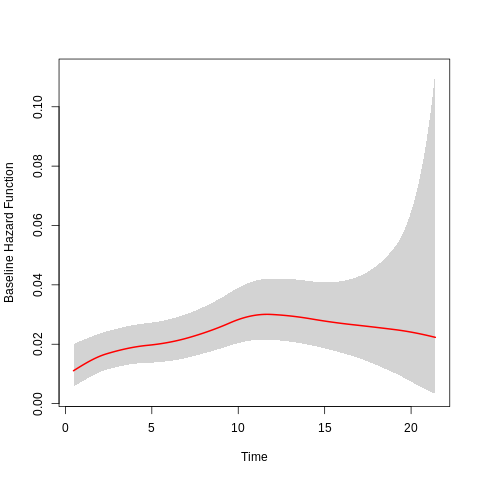

In [20]:
%%R
JMbayes2:::plot_hazard(jointFit5)

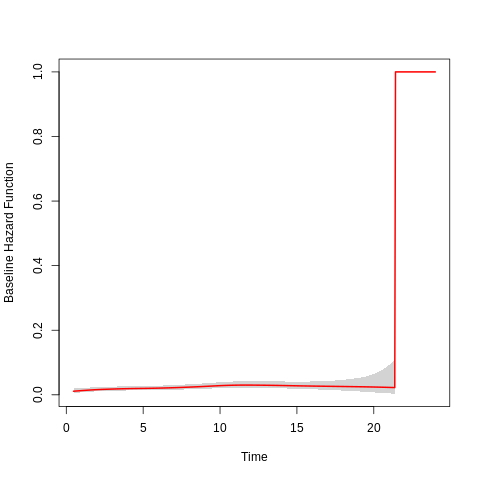

In [21]:
%%R
# Extrapolate to month 24
JMbayes2:::plot_hazard(jointFit5, tmax = 24)


- Equivalent to modeling $ \log h_0(t) = \beta_0 + \beta_1 \log t $,
- **Fully parametric** → enables reliable extrapolation,
- Only 2 parameters → less flexible but more stable with small samples.

> Ideal when proportional hazards and Weibull shape are plausible.



#### Stratified Baseline Hazards


Allow different $ h_0(t) $ per group (e.g., by treatment).


In [22]:
%%R
# Refit Cox model with stratification
CoxFit2 <- coxph(Surv(Time, death) ~ strata(drug), data = aids.id)

# Fit joint model with different baseline hazards per stratum
jointFit6 <- jm(CoxFit2, fm, time_var = "obstime",
                base_hazard = c("weibull", "log time, ns"))
summary(jointFit6)


Call:
jm(Surv_object = CoxFit2, Mixed_objects = fm, time_var = "obstime", 
    base_hazard = c("weibull", "log time, ns"))

Data Descriptives:
Number of Groups: 467		Number of events: 188 (40.3%)
Number of Observations:
  sqrt(CD4): 1405

                 DIC     WAIC      LPML
marginal    4112.391 4207.099 -2103.847
conditional 6119.611 5829.833 -3376.826

Random-effects covariance matrix:
                           
       StdDev   Corr       
(Intr) 0.8709 (Intr) n(,2)1
n(,2)1 0.6518              
n(,2)2 0.2460              

Survival Outcome:
                    Mean  StDev   2.5%   97.5% P   Rhat
1                 0.0000 0.0000  0.000  0.0000 0    NaN
value(sqrt(CD4)) -1.0681 0.1573 -1.373 -0.7561 0 1.0101

Longitudinal Outcome: sqrt(CD4) (family = gaussian, link = identity)
                   Mean  StDev    2.5%   97.5%      P   Rhat
(Intercept)      2.5009 0.0605  2.3832  2.6207 0.0000 1.0046
ns(obstime, 2)1 -0.7573 0.0836 -0.9214 -0.5951 0.0000 1.0024
ns(obstime, 2)2 -0.4009 0

In [ ]:
%%R
# Plot both strata
# JMbayes2:::plot_hazard(jointFit6)


- First element (`"weibull"`) → for first level of `drug` (e.g., ddC),
- Second (`"log time, ns"`) → for second level (e.g., ddI),
- Use `NA` to apply the default to a stratum: `c("weibull", NA)`.

> Useful when proportional hazards assumption is violated across groups.


#### Summary Table of Options


| Specification                | `base_hazard` value               | Smooth? | Extrapolation? | Notes |
|-----------------------------|-----------------------------------|--------|----------------|------|
| Default B-splines           | (default)                         | Yes     | Limited        | Quadratic, penalized |
| Natural cubic splines (log) | `"log time, ns"`                  | No     | Yes             | Recommended default |
| Piecewise constant          | `"piecewise constant"`            | No     | No             | Simple, robust |
| Piecewise linear            | `"piecewise linear, log time"`    | -     | -              | Linear segments |
| Weibull                     | `"weibull"`                       | Yes     | es             | Fully parametric |
| Stratified                  | `c("weibull", "log time, ns")`    | Depends| Depends        | Per-group flexibility |



###  Practical Tips


- **Start with `"log time, ns"`** — it often provides the best balance of flexibility and stability.
- Use **Weibull** if you need to **extrapolate** (e.g., for long-term survival predictions).
- Always **inspect `plot_hazard()`** to assess smoothness and plausibility.
- For **stratified models**, ensure your `coxph()` model uses `strata()`.


## Summary and Conclusion


In joint modeling of longitudinal and time-to-event data, the **baseline hazard function** $ h_0(t) $ plays a crucial role in defining the risk of an event over time. The {JMbayes2} package in R provides flexible options to specify and estimate $ h_0(t) $, allowing researchers to tailor the model to their data and research questions. By choosing appropriate baseline hazard specifications—ranging from penalized B-splines to parametric forms like Weibull—analysts can capture the underlying hazard dynamics effectively, leading to more accurate inferences and predictions. Careful consideration of the baseline hazard structure, along with thorough model diagnostics, is essential for robust joint modeling analyses.


## Resources


- Rizopoulos, D. (2025). *Baseline Hazard Function*. `JMbayes2` Vignette.  
  https://drizopoulos.github.io/JMbayes2/articles/Baseline_Hazard.html
- Rizopoulos, D. (2012). *Joint Models for Longitudinal and Time-to-Event Data*. Chapman & Hall/CRC.
